# From IMDb: the Top-rated Movies

### *Katherine Li*

**A web scraping session using *BeautifulSoup* + Some Preliminary Analysis on the Data**

The first section of this project scrapes the movies released in 2020 and their respective information. <br>
The second section scrapes from multiple pages (i.e. top movies released in different years) and a distribution analysis regarding the scraped result. <br>
The third part scrapes the all-time top-rated movies according to IMDb.com. 


## Movies Released in 2020

The first part scrapes the movies released specifically in 2020 and their respective information. The original website can be found [here](https://www.imdb.com/search/title?release_date=2020&sort=num_votes,desc&page=1).


In [8]:
# Movies released in 2020

# Get package and url 
from requests import get
url = 'https://www.imdb.com/search/title?release_date=2020&sort=num_votes,desc&page=1'
response = get(url)
print(response.text[:500])



<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///?src=mdot">



        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle",


In [9]:
#Parse response.text by creating a BeautifulSoup object, and assign this object to html_soup. The 'html.parser' argument indicates that we want to use Python’s built-in HTML parser for the parsing.
from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [10]:
#Use the find_all() method to extract all the div containers that have a class attribute of lister-item mode-advanced:

movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
print(type(movie_containers))
print(len(movie_containers))

<class 'bs4.element.ResultSet'>
50


In [11]:
#See how information looks like for one single movie, accessing the first container

first_movie = movie_containers[0]
first_movie

<div class="lister-item mode-advanced">
<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt6723592"></div>
</div>
<div class="lister-item-image float-left">
<a href="/title/tt6723592/"> <img alt="Tenet" class="loadlate" data-tconst="tt6723592" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BYzg0NGM2NjAtNmIxOC00MDJmLTg5ZmYtYzM0MTE4NWE2NzlhXkEyXkFqcGdeQXVyMTA4NjE0NjEy._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png" width="67"/>
</a> </div>
<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt6723592/">Tenet</a>
<span class="lister-item-year text-muted unbold">(2020)</span>
</h3>
<p class="text-muted">
<span class="certificate">PG-13</span>
<span class="ghost">|</span>
<span class="runtime">150 min</span>
<span class="ghost">|</span>
<span class="genre">
Action, Sci-Fi, Thriller            </

**Now the actual part of scraping the information begins!**

In [12]:
# Lists to store the scraped data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []
# Extract data from individual movie container
for container in movie_containers:
# If the movie has Metascore, then extract:
    if container.find('div', class_ = 'ratings-metascore') is not None:
# The name
      name = container.h3.a.text
      names.append(name)
# The year
      year = container.h3.find('span', class_ = 'lister-item-year').text
      years.append(year)
# The IMDB rating
      imdb = float(container.strong.text)
      imdb_ratings.append(imdb)
# The Metascore
      m_score = container.find('span', class_ = 'metascore').text
      metascores.append(int(m_score))
# The number of votes
      vote = container.find('span', attrs = {'name':'nv'})['data-value']
      votes.append(int(vote))

Output the table using pandas.

In [49]:
import pandas as pd
test_df = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes
})
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3612 entries, 0 to 3611
Data columns (total 5 columns):
movie        3612 non-null object
year         3612 non-null object
imdb         3612 non-null float64
metascore    3612 non-null int64
votes        3612 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 141.2+ KB
None


,movie,year,imdb,metascore,votes
0,Gladiator,(2000),8.5,67,1364019
1,Memento,(2000),8.4,80,1143216
2,Snatch,(2000),8.3,55,793374
3,Requiem for a Dream,(2000),8.3,68,779016
4,X-Men,(2000),7.4,64,577720
...,...,...,...,...,...
3607,Rocketman,(I) (2019),7.3,69,147407
3608,Zombieland: Double Tap,(2019),6.7,55,146465
3609,6 Underground,(2019),6.1,41,145248
3610,Frozen II,(2019),6.8,64,143532


## Top Yearly Movies Released from 2000 to 2020

In this section, scrape data of the top movies released in each year from the span of 2000 to 2020 (the first 5 pages for each year). Then piece everything together and conduct some preliminary analysis.

### Data Scraping

In [50]:
pages = [str(i) for i in range(1,5)]
years_url = [str(i) for i in range(2000,2020)]

In [20]:
# Redeclaring the lists to store data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []

headers = {"Accept-Language": "en-US, en;q=0.5"}

# Preparing the monitoring of the loop
#start_time = time()
#requests = 0

# For every year in the interval 2000-2017
for year_url in years_url:

    # For every page in the interval 1-4
    for page in pages:

        # Make a get request
        response = get('https://www.imdb.com/search/title?release_date=' + year_url +
        '&sort=num_votes,desc&page=' + page, headers = headers)

        # Pause the loop
       # sleep(randint(8,15))

        # Monitor the requests
        #requests += 1
       # elapsed_time = time() - start_time
        #print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        #clear_output(wait = True)

        # Throw a warning for non-200 status codes
       # if response.status_code != 200:
         #   warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
       # if requests > 72:
        #    warn('Number of requests was greater than expected.')
       #     break

        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')

        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            if container.find('div', class_ = 'ratings-metascore') is not None:

                # Scrape the name
                name = container.h3.a.text
                names.append(name)

                # Scrape the year
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                # Scrape the IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)

                # Scrape the Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))

                # Scrape the number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))

Take a peep at the scraped data.

In [56]:
movie_ratings = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'metascore': metascores,
'votes': votes
})
print(movie_ratings.info())
movie_ratings.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3612 entries, 0 to 3611
Data columns (total 5 columns):
movie        3612 non-null object
year         3612 non-null object
imdb         3612 non-null float64
metascore    3612 non-null int64
votes        3612 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 141.2+ KB
None


,movie,year,imdb,metascore,votes
0,Gladiator,(2000),8.5,67,1364019
1,Memento,(2000),8.4,80,1143216
2,Snatch,(2000),8.3,55,793374
3,Requiem for a Dream,(2000),8.3,68,779016
4,X-Men,(2000),7.4,64,577720
5,Cast Away,(2000),7.8,73,535508
6,American Psycho,(2000),7.6,64,505469
7,Unbreakable,(2000),7.3,62,392033
8,Mission: Impossible II,(2000),6.1,59,318855
9,Meet the Parents,(2000),7.0,73,314507


### Data Cleaning

- Reordering the columns.
- Cleaning the year column and convert the values to integers.
- Checking the extreme rating values to determine if all the ratings are within the expected intervals.
- Normalizing one of the ratings type (or both) for generating a comparative histogram.

Step 1: Reordering the columns.

In [57]:
movie_ratings = movie_ratings[['movie', 'year', 'imdb', 'metascore', 'votes']]
movie_ratings.head()

,movie,year,imdb,metascore,votes
0,Gladiator,(2000),8.5,67,1364019
1,Memento,(2000),8.4,80,1143216
2,Snatch,(2000),8.3,55,793374
3,Requiem for a Dream,(2000),8.3,68,779016
4,X-Men,(2000),7.4,64,577720


Step 2: Cleaning the year column and convert the values to integers.

First, examine the unique values of the year column.

In [58]:
movie_ratings['year'].unique()


array(['(2000)', '(I) (2000)', '(2001)', '(2002)', '(2003)', '(2004)',
       '(I) (2004)', '(2005)', '(I) (2005)', '(2006)', '(I) (2006)',
       '(2007)', '(I) (2007)', '(2008)', '(I) (2008)', '(2009)',
       '(I) (2009)', '(2010)', '(I) (2010)', '(2011)', '(I) (2011)',
       '(2012)', '(I) (2012)', '(2013)', '(I) (2013)', '(2014)',
       '(I) (2014)', '(II) (2014)', '(2015)', '(I) (2015)', '(II) (2015)',
       '(2016)', '(II) (2016)', '(IX) (2016)', '(I) (2016)', '(2017)',
       '(I) (2017)', '(2018)', '(I) (2018)', '(III) (2018)', '(2019)',
       '(II) (2019)', '(I) (2019)'], dtype=object)

It is obvious that the years are always located from the fifth character to the second. Use the .str() method to select only that interval, and convert the result to an integer using the astype() method.


In [59]:
import numpy as np

movie_ratings.loc[:, 'year'] = movie_ratings['year'].str[-5:-1].astype(int)

#import re

#movie_ratings.loc[:, 'year'] = re.sub("[^0-9]","",movie_ratings['year'])


movie_ratings['year'].head(7)


0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
Name: year, dtype: int32

Step 3: Check the extreme rating values to determine if all the ratings are within the expected intervals.

In [60]:
movie_ratings.describe().loc[['min', 'max'], ['imdb', 'metascore']]


,imdb,metascore
min,4.1,24.0
max,9.0,100.0


There are no unexpected outliers.


Step 4: From the values above, you can see that the two ratings have different scales. To be able to plot the two distributions on a single graph, bring them to the same scale by normalizing the imdb column to a 100-points scale. Multiply each IMDB rating by 10, and do a quick check by looking at the first 3 rows:



In [61]:
movie_ratings['n_imdb'] = movie_ratings['imdb'] * 10
movie_ratings.head(3)

,movie,year,imdb,metascore,votes,n_imdb
0,Gladiator,2000,8.5,67,1364019,85.0
1,Memento,2000,8.4,80,1143216,84.0
2,Snatch,2000,8.3,55,793374,83.0


### Data Visualization

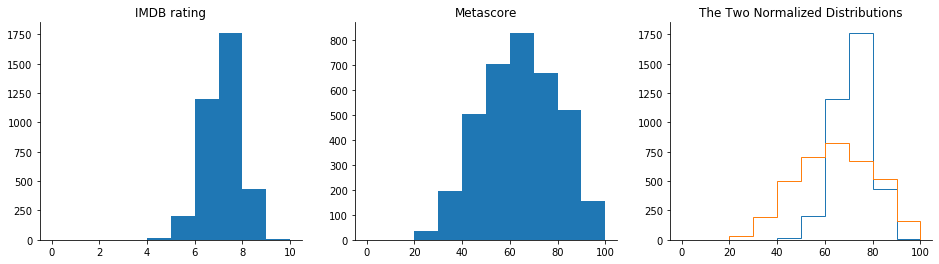

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(movie_ratings['imdb'], bins = 10, range = (0,10)) # bin range = 1
ax1.set_title('IMDB rating')
ax2.hist(movie_ratings['metascore'], bins = 10, range = (0,100)) # bin range = 10
ax2.set_title('Metascore')
ax3.hist(movie_ratings['n_imdb'], bins = 10, range = (0,100), histtype = 'step')
ax3.hist(movie_ratings['metascore'], bins = 10, range = (0,100), histtype = 'step')
#ax3.legend(loc = 'upper left')
ax3.set_title('The Two Normalized Distributions')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

### Findings

Most IMDb ratings are between 6 and 8, there are few movies with a rating greater than 8, and even fewer with a rating smaller than 4. This indicates that both very good movies and very bad movies are rarer.

The distribution of Metascore ratings resembles a normal distribution – most ratings are average, peaking at the value of approximately 50. From this peak, the frequencies gradually decrease toward extreme rating values on both sides. 

From the comparative graph, it’s clearer that the IMDB distribution is highly skewed toward the higher part of the average ratings, while the Metascore ratings seem to have a much more balanced distribution.

**Next Steps...**
What might cause the IMDb ratings to appear more skewed than does the Metascore?


## All-time Top Movies on IMDb.com

Now the third section of this projects scrapes information regarding the all-time top movies from IMDb.com. The original website could be found [here](http://www.imdb.com/chart/top).


In [11]:
import requests
import re

# Download IMDB's Top 250 data
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]
votes = [b.attrs.get('data-value') for b in soup.select('td.ratingColumn strong')]

imdb = []

# Store each item into dictionary (data), then put those into a list (imdb)
for index in range(0, len(movies)):
    # Seperate movie into: 'place', 'title', 'year'
    movie_string = movies[index].get_text()
    movie = (' '.join(movie_string.split()).replace('.', ''))
    movie_title = movie[len(str(index))+1:-7]
    year = re.search('\((.*?)\)', movie_string).group(1)
    place = movie[:len(str(index))-(len(movie))]
    data = {"movie_title": movie_title,
            "year": year,
            "place": place,
            "star_cast": crew[index],
            "rating": ratings[index],
            "vote": votes[index],
            "link": links[index]}
    imdb.append(data)

for item in imdb:
    print(item['place'], '-', item['movie_title'], '('+item['year']+') -', 'Starring:', item['star_cast'])

1 - The Shawshank Redemption (1994) - Starring: Frank Darabont (dir.), Tim Robbins, Morgan Freeman
2 - The Godfather (1972) - Starring: Francis Ford Coppola (dir.), Marlon Brando, Al Pacino
3 - The Godfather: Part II (1974) - Starring: Francis Ford Coppola (dir.), Al Pacino, Robert De Niro
4 - The Dark Knight (2008) - Starring: Christopher Nolan (dir.), Christian Bale, Heath Ledger
5 - 12 Angry Men (1957) - Starring: Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb
6 - Schindler's List (1993) - Starring: Steven Spielberg (dir.), Liam Neeson, Ralph Fiennes
7 - The Lord of the Rings: The Return of the King (2003) - Starring: Peter Jackson (dir.), Elijah Wood, Viggo Mortensen
8 - Pulp Fiction (1994) - Starring: Quentin Tarantino (dir.), John Travolta, Uma Thurman
9 - The Good, the Bad and the Ugly (1966) - Starring: Sergio Leone (dir.), Clint Eastwood, Eli Wallach
1 -  The Lord of the Rings: The Fellowship of the Ring (2001) - Starring: Peter Jackson (dir.), Elijah Wood, Ian McKellen
11 - Fi

Makes it look better with pandas. Show all rows.

In [16]:
imdb_df = pd.DataFrame(imdb)

pd.set_option('display.max_rows', imdb_df.shape[0]+1)

imdb_df

,movie_title,year,place,star_cast,rating,vote,link
0,The Shawshank Redemption,1994,1,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",9.219578158515473,None,/title/tt0111161/
1,The Godfather,1972,2,"Francis Ford Coppola (dir.), Marlon Brando, Al...",9.14749576670067,None,/title/tt0068646/
2,The Godfather: Part II,1974,3,"Francis Ford Coppola (dir.), Al Pacino, Robert...",8.97983715793398,None,/title/tt0071562/
3,The Dark Knight,2008,4,"Christopher Nolan (dir.), Christian Bale, Heat...",8.969327451981416,None,/title/tt0468569/
4,12 Angry Men,1957,5,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",8.934273321261427,None,/title/tt0050083/
5,Schindler's List,1993,6,"Steven Spielberg (dir.), Liam Neeson, Ralph Fi...",8.909229710666965,None,/title/tt0108052/
6,The Lord of the Rings: The Return of the King,2003,7,"Peter Jackson (dir.), Elijah Wood, Viggo Morte...",8.88495411208423,None,/title/tt0167260/
7,Pulp Fiction,1994,8,"Quentin Tarantino (dir.), John Travolta, Uma T...",8.838552988720838,None,/title/tt0110912/
8,"The Good, the Bad and the Ugly",1966,9,"Sergio Leone (dir.), Clint Eastwood, Eli Wallach",8.78828518516573,None,/title/tt0060196/
9,The Lord of the Rings: The Fellowship of the ...,2001,1,"Peter Jackson (dir.), Elijah Wood, Ian McKellen",8.776385521534516,None,/title/tt0120737/
